In [19]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import eurostat

code = "SDG_08_10"
filter_pars = {"unit": "CLV10_EUR_HAB"}
data_real_gdp = eurostat.get_data_df(code, filter_pars=filter_pars)
data_real_gdp = data_real_gdp.drop(columns=["freq", "na_item", "unit"])
data_real_gdp = data_real_gdp.rename(columns={"geo\TIME_PERIOD": "GeoName"})
data_real_gdp = data_real_gdp.melt(["GeoName"], var_name="Year", value_name="Real GDP per capita")
data_real_gdp["log GDP per capita"] = numpy.log(data_real_gdp["Real GDP per capita"])
data_real_gdp.head()

,GeoName,Year,Real GDP per capita,log GDP per capita
0,AL,2000,1700.0,7.438384
1,AT,2000,31710.0,10.364387
2,BE,2000,29890.0,10.305279
3,BG,2000,2990.0,8.003029
4,CH,2000,51950.0,10.858037


In [29]:
first_year = "2000"
last_year = "2019"

data_growth = data_real_gdp[data_real_gdp["Year"].isin([first_year, last_year])].reset_index(drop=True)
data_growth = data_growth.sort_values(["GeoName", "Year"]).reset_index(drop=True)
data_growth["log GDP per capita 2000"] = data_growth.groupby("GeoName")["log GDP per capita"].shift()
data_growth = data_growth[data_growth["Year"] == last_year]
data_growth["Ratio"] = data_growth["log GDP per capita"] / data_growth["log GDP per capita 2000"]
data_growth.head(20)

,GeoName,Year,Real GDP per capita,log GDP per capita,log GDP per capita 2000,Ratio
1,AL,2019,3920.0,8.273847,7.438384,1.112318
3,AT,2019,38090.0,10.547707,10.364387,1.017687
5,BE,2019,36120.0,10.494602,10.305279,1.018371
7,BG,2019,6630.0,8.799360,8.003029,1.099504
9,CH,2019,61950.0,11.034083,10.858037,1.016213
11,CY,2019,25500.0,10.146434,9.909967,1.023862
13,CZ,2019,18460.0,9.823362,9.326344,1.053292
15,DE,2019,35950.0,10.489884,10.271943,1.021217
17,DK,2019,48970.0,10.798963,10.649939,1.013993
19,EA19,2019,31300.0,10.351373,10.184523,1.016383


c:\Users\jirip\repos\DKMEN\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jirip\repos\DKMEN\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jirip\repos\DKMEN\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jirip\repos\DKMEN\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


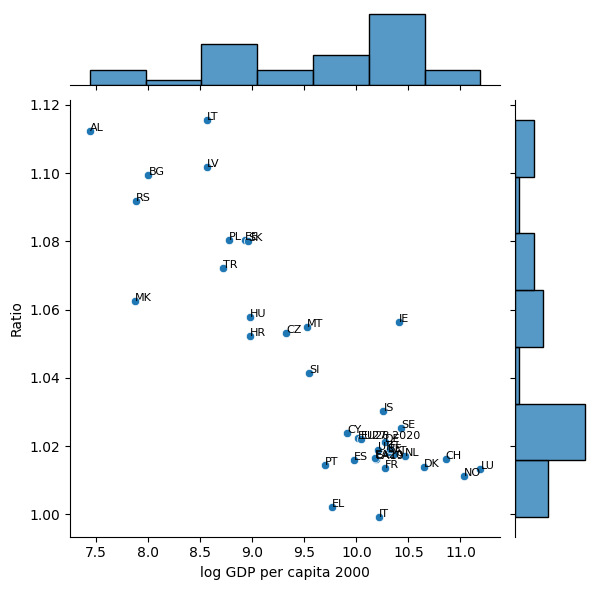

In [30]:
sns.jointplot(data_growth, x=f"log GDP per capita {first_year}", y="Ratio", kind="scatter")
for line in range(0, data_growth.shape[0]):
    plt.annotate(data_growth["GeoName"].iloc[line], (data_growth[f"log GDP per capita {first_year}"].iloc[line], data_growth["Ratio"].iloc[line]), fontsize=8)